<a href="https://colab.research.google.com/github/felipednegredo/Spatial-Filtering-Toolkit/blob/main/Projeto_M1_%E2%80%93_Opera%C3%A7%C3%B5es_Pontuais_e_Filtragem_Espacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação Filtro de Difusão Anisotrópica**

## **Pré-Processamento**

###importando as bibliotecas

In [ ]:
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from google.colab.patches import cv2_imshow
import random
from ipywidgets import interact, IntSlider, FloatSlider, Button
from IPython.display import display, clear_output

###Carregando Arquivos do Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

###Carregando imagem base


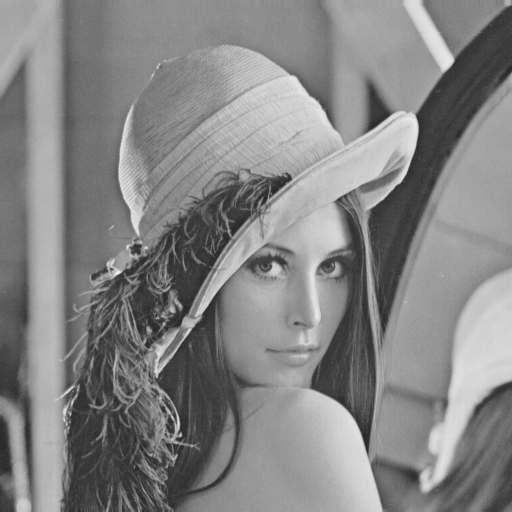

In [ ]:
# Carrega a Imagem
#img_base = cv2.imread("Lena.png",0)
#img_base = cv2.imread("/content/drive/MyDrive/lena.png",0)

img_base = cv2.imread("Lenna512.png",0)
# Mostra a imagem
cv2_imshow(img_base)

###Adicionando Ruído

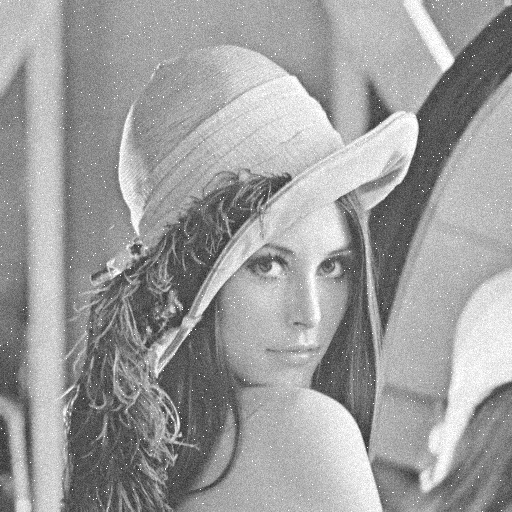

In [ ]:
def add_gaussian_noise(image, mean=25, std=10):
    """
    Adiciona ruído a imagem passada por parâmetro, com base em uma função normal
    para o cálculo dos valores do ruído distribuídos aleatóriamente pela imagem.

    image = imagem onde será adicionado ruído
    mean = média do valor do ruído
    std = desvio padrão do ruído
    """
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

img_ruido = add_gaussian_noise(img_base)
cv2_imshow(img_ruido)

###Função de padding

In [ ]:
def add_padding(img, padding_height, padding_width):
    n, m = img.shape

    padded_img = np.zeros((n + padding_height * 2, m + padding_width * 2))
    padded_img[padding_height : n + padding_height, padding_width : m + padding_width] = img

    return padded_img

##**Filtro Gaussiano**

array([[108, 146, 144, ..., 149, 141,  95],
       [151, 197, 190, ..., 199, 186, 127],
       [161, 201, 189, ..., 199, 184, 127],
       ...,
       [ 56,  75,  79, ..., 130, 136, 103],
       [ 55,  75,  82, ..., 135, 138, 102],
       [ 44,  63,  67, ..., 105, 104,  77]], dtype=uint8)
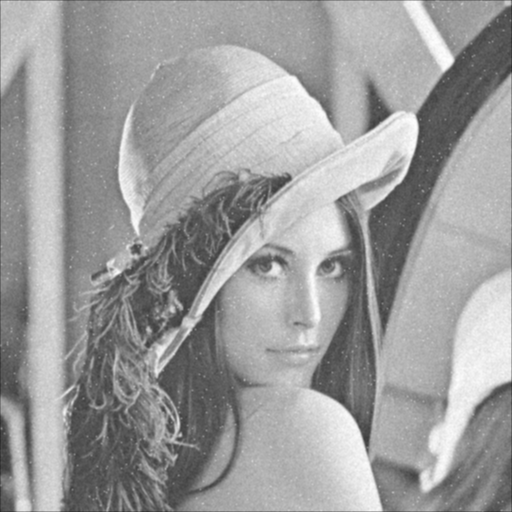

In [ ]:
def filtro_Gaussiano(img, kernel, padding=True):
    k_height, k_width = kernel.shape
    img_height, img_width = img.shape

    pad_height = k_height // 2
    pad_width = k_width // 2
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution
    for i_img in range(img_height):  # Loop usando i
        for j_img in range(img_width):  # Loop usando j
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
            output[i_img, j_img] = int(output[i_img, j_img])
    return np.array(output, dtype=np.uint8)

kernel = np.array(([1, 2, 1],
                   [2, 4, 2],
                   [1, 2, 1]), dtype=np.float32)
kernel /= np.sum(kernel)  # Normaliza o kernel

img_gauss = filtro_Gaussiano(img_ruido, kernel)
img_gauss

##**Filtro de Difusão Anisotrópica (FDA)**

> Adicionar aspas





### Cálculo dos pixels adjacentes

In [ ]:
def adjacentes(img, kernel, pixel, i_img, j_img, padding=True):
    adjacentes = np.zeros(kernel.shape)
    k_height, k_width = kernel.shape

    pad_height = k_height // 2
    pad_width = k_width // 2
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)

    for i in range(k_height):
        for j in range (k_width):
            adjacentes[i,j] = padded_img[i_img + i, j_img + j]
        adjacentes[k_height//2, k_width//2] = pixel
    return adjacentes.astype(np.uint8)

### Função Ômega

In [ ]:
def omega(lamb,tau,valor):
    return (1-np.exp(-8*tau*np.exp((-(np.abs(valor)**(1./5))/lamb)/5)))/8

###Função para cálculo dos pesos

In [ ]:
def calcula_pesos(adjacente, pixel, lamb, tau):
    pesos = np.zeros((3, 3))
    k_height, k_width = pesos.shape
    for i in range(k_height):
        for j in range(k_width):
            valor = int(pixel) - int(adjacente[i, j])
            pesos[i, j] = omega(lamb, tau, valor)
    pesos[k_height//2, k_width//2] = 1 - (np.sum(pesos) - pesos[k_height//2, k_width//2])
    return pesos

### Função para geração da LUT

In [ ]:
def LUT(lamb, tau):
    LUT = np.zeros(256)
    for i in range(256):
        LUT[i] = omega(lamb,tau,i)
    return LUT

inicio_lut = time()
LUT(15, 0.1)
fim_lut = time()
tempo_lut = fim_lut - inicio_lut
print(tempo_lut)

0.0019636154174804688


### Calculo dos pesos com a LUT

In [ ]:
def calcula_pesos_LUT(adjacente, pixel, lut):
    pesos = np.zeros((3, 3))
    k_height, k_width = pesos.shape
    for i in range(k_height):
        for j in range(k_width):
            valor = int(pixel) - int(adjacente[i,j])
            pesos[i, j] = lut[valor]
    pesos[k_height//2, k_width//2] = 1 - (np.sum(pesos) - pesos[k_height//2, k_width//2])
    return pesos

#**Aplicação Filtro Anisotrópico**


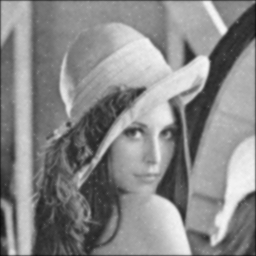

55.1308217048645


In [ ]:
def FDA(img, kernel, lamb, tau, t, padding=True, table = True):
    # Get dimensions of the kernel
    k_height, k_width = kernel.shape  # Atribui valor à variável k_height, k_width

    # Get dimensions of the image
    img_height, img_width = img.shape  # Atribui valor à variável img_height, img_width

    # Calculate padding required
    pad_height = k_height // 2  # Atribui valor à variável pad_height
    pad_width = k_width // 2  # Atribui valor à variável pad_width

    # Create a padded version of the image to handle edges
    if padding == True:
        padded_img = add_padding(img, pad_height, pad_width)  # Atribui valor à variável padded_img

    if table == True:
        lut = LUT(lamb,tau)

    # Initialize an output image with zeros
    output = np.zeros((img_height, img_width), dtype=float)  # Atribui valor à variável output

    # Perform convolution rep times
    for k in range(t):
        for i_img in range(img_height):  # Loop usando i
            for j_img in range(img_width):  # Loop usando j
                pixel = img[i_img,j_img]
                adjacente = adjacentes(img, kernel, pixel, i_img, j_img, padding)
                if table == True:
                    kernel = calcula_pesos_LUT(adjacente, pixel, lut)
                else:
                    kernel = calcula_pesos(adjacente, pixel, lamb, tau)
                for i_kernel in range(k_height):
                    for j_kernel in range(k_width):
                        output[i_img, j_img] = output[i_img, j_img] + (padded_img[i_img+i_kernel, j_img+j_kernel] * kernel[i_kernel, j_kernel])  # Atribui valor à variável output[i, j]
                output[i_img, j_img] = int(output[i_img, j_img])
        img = output.copy()
        output = np.zeros((img_height, img_width), dtype=float)
        if padding == True:
            padded_img = add_padding(img, pad_height, pad_width)

    return np.array(img, dtype=np.uint8)

kernel = np.zeros((3,3))
inicio = time()
img_filtro = FDA(img_ruido,kernel, 15, 0.001, 10, table = True)
fim = time()
cv2_imshow(img_filtro)

tempo = fim - inicio
print(tempo)

###Sliders

interactive(children=(FloatSlider(value=4.0, description='Lambda: ', max=15.0, min=1.0, step=0.5), FloatSlider…

Button(description='Update', style=ButtonStyle())

array([[135, 145, 156, ..., 122, 141, 126],
       [140, 178, 175, ..., 125, 129,  92],
       [143, 177, 172, ..., 126,  66,  68],
       ...,
       [ 62,  70,  81, ...,  72,  65,  67],
       [ 57,  62,  74, ...,  65,  80,  81],
       [ 41,  58,  57, ...,  71, 105,  96]], dtype=uint8)
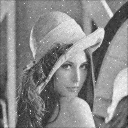

array([[ 65,  94, 104, ...,  78,  76,  53],
       [ 91, 141, 154, ..., 110,  97,  60],
       [ 98, 149, 165, ..., 107,  80,  51],
       ...,
       [ 42,  66,  88, ...,  71,  64,  44],
       [ 35,  56,  74, ...,  66,  66,  48],
       [ 21,  37,  46, ...,  47,  53,  39]], dtype=uint8)
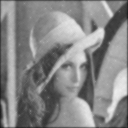

array([[ 79, 106, 116, ...,  89,  89,  68],
       [102, 152, 162, ..., 116, 105,  69],
       [109, 157, 169, ..., 111,  80,  54],
       ...,
       [ 46,  67,  86, ...,  71,  65,  49],
       [ 41,  60,  75, ...,  68,  73,  57],
       [ 25,  41,  49, ...,  53,  64,  51]], dtype=uint8)
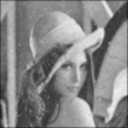

array([[ 44,  72,  83, ...,  61,  53,  33],
       [ 70, 116, 135, ...,  94,  78,  46],
       [ 80, 133, 154, ...,  98,  76,  44],
       ...,
       [ 35,  64,  90, ...,  68,  57,  35],
       [ 28,  51,  73, ...,  60,  54,  34],
       [ 16,  30,  42, ...,  37,  36,  23]], dtype=uint8)
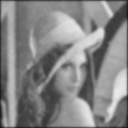

array([[ 24,  44,  56, ...,  38,  29,  15],
       [ 43,  78, 100, ...,  67,  50,  26],
       [ 55,  99, 127, ...,  79,  58,  31],
       ...,
       [ 29,  57,  84, ...,  59,  45,  24],
       [ 21,  42,  63, ...,  46,  35,  19],
       [ 10,  22,  34, ...,  25,  20,  10]], dtype=uint8)
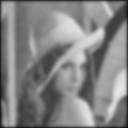

array([[ 18,  34,  45, ...,  30,  22,  11],
       [ 34,  63,  84, ...,  54,  39,  20],
       [ 45,  84, 110, ...,  68,  49,  25],
       ...,
       [ 26,  53,  78, ...,  53,  38,  20],
       [ 19,  38,  57, ...,  39,  29,  15],
       [ 10,  20,  30, ...,  21,  15,   8]], dtype=uint8)
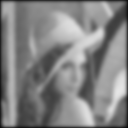

array([[14, 27, 37, ..., 24, 17,  9],
       [27, 52, 70, ..., 45, 32, 16],
       [37, 70, 95, ..., 59, 41, 21],
       ...,
       [24, 49, 72, ..., 48, 33, 17],
       [17, 35, 52, ..., 34, 24, 12],
       [ 9, 18, 27, ..., 18, 12,  6]], dtype=uint8)
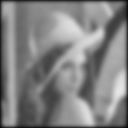

array([[12, 24, 33, ..., 21, 15,  7],
       [24, 45, 63, ..., 40, 28, 14],
       [33, 63, 87, ..., 53, 37, 19],
       ...,
       [23, 46, 68, ..., 44, 31, 16],
       [16, 33, 48, ..., 32, 22, 11],
       [ 8, 17, 25, ..., 16, 11,  5]], dtype=uint8)
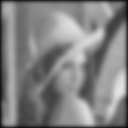

In [ ]:
lamb_slider = FloatSlider(min = 1, max = 15, value = 4, step = 0.5, description = "Lambda: ")
tau_slider = FloatSlider(min = 0.001, max = 0.500, value = 0.025, step = 0.001, description = "tau: ")
t_slider = IntSlider(min = 0, max = 200, value = 10, step = 2, description = "Repetições: ")
update_button = Button(description="Update")

# Define update function
def update_function(button):
    lamb = lamb_slider.value
    tau = tau_slider.value
    t = t_slider.value
    global img_ruido
    kernel = np.zeros((3, 3))
    img_filtro = FDA(img_ruido, kernel, lamb, tau, t, table=True)
    display(img_filtro)  # Display new image

# Register button click event
update_button.on_click(update_function)

# Create interactive sliders
interact(lambda lamb, tau, t: None, lamb=lamb_slider, tau=tau_slider, t=t_slider)
display(update_button)

##**Métricas**

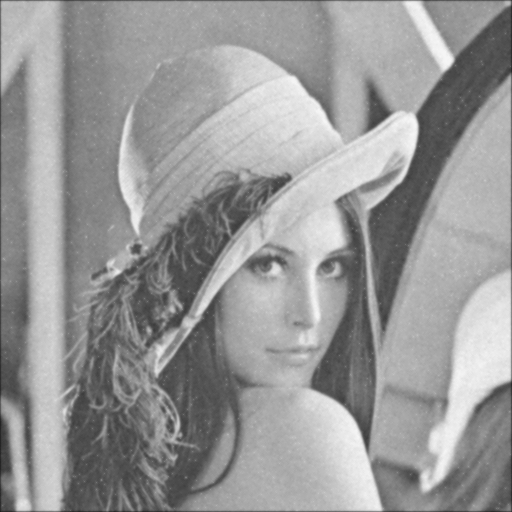

PSNR: 21.66 dB
MSE: 113.52


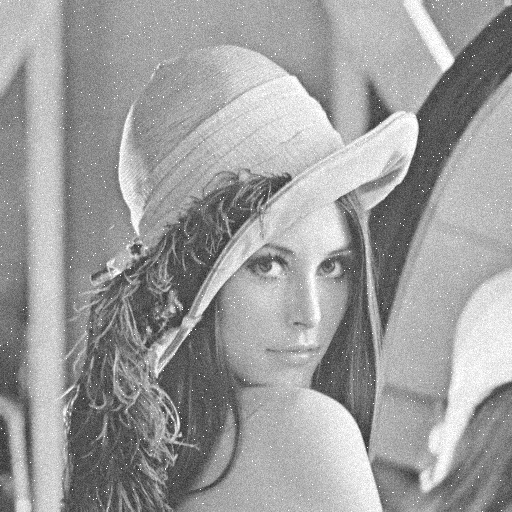

PSNR: 19.23 dB
MSE: 113.15


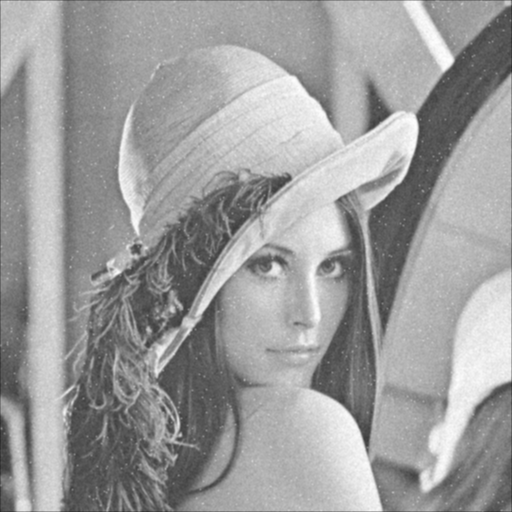

PSNR_gauss: 20.09 dB
MSE_gauss: 116.51


In [ ]:
img_filtro2 = cv2.imread("Lenna512_15_0.025_10.png",0)
cv2_imshow(img_filtro2)

# Avaliação de desempenho (PSNR e MSE)
psnr = cv2.PSNR(img_base, img_filtro2)
mse = np.mean((img_base - img_filtro2)**2)

print(f"PSNR: {psnr:.2f} dB")
print(f"MSE: {mse:.2f}")

# Analisando imagem com ruído

psnr_ruido = cv2.PSNR(img_base, img_ruido)
mse_ruido = np.mean((img_base - img_ruido)**2)

cv2_imshow(img_ruido)
print(f"PSNR: {psnr_ruido:.2f} dB")
print(f"MSE: {mse_ruido:.2f}")

# Comparação com filtro gaussiano 3x3 (use cv2.GaussianBlur)
cv2_imshow(img_gauss)

psnr_gauss = cv2.PSNR(img_base, img_gauss)
mse_gauss = np.mean((img_base - img_gauss)**2)

print(f"PSNR_gauss: {psnr_gauss:.2f} dB")
print(f"MSE_gauss: {mse_gauss:.2f}")